<a href="https://colab.research.google.com/github/svssp787/Deep-Learning/blob/main/Part%20A/Assignment_2_Q1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Activation, MaxPooling2D, BatchNormalization, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.regularizers import l2

import numpy as np
import os
import glob
import cv2 as cv
import matplotlib.pyplot as plt

In [ ]:
!pip install wandb

import wandb

wandb.init(project="Assignment 2", entity="cs21m053-cs21m071")

wandb: Currently logged in as: cs21m053 (use `wandb login --relogin` to force relogin)


In [ ]:
from google.colab import drive

drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
!unzip -qq "/content/drive/My Drive/inaturalist.zip" -d "/content"

In [ ]:

def ds_generation(data_augmentation):
 # test_datagen = ImageDataGenerator(rescale = 1./255)
  if not data_augmentation:
    train_datagen = ImageDataGenerator(rescale = 1./255,validation_split = 0.1)
  else:
    train_datagen = ImageDataGenerator(rescale = 1./255,
      shear_range = 0.1,
      rotation_range=20,
      width_shift_range=0.2,
      zoom_range = 0.2,
      height_shift_range=0.2,
      horizontal_flip=True,
      validation_split=0.1
      )
  train_ds = train_datagen.flow_from_directory(
    "/content/inaturalist_12K/train/",
    batch_size = 9000,
    subset="training",
    target_size=(128, 128),
    class_mode='categorical'
  )
  val_ds =train_datagen.flow_from_directory(
    "/content/inaturalist_12K/train/",
    batch_size = 999,
    subset="validation",
    target_size=(128, 128)
    ,
    class_mode='categorical'
  )

  return train_ds,val_ds

train_da_ds, val_da_ds = ds_generation(True)
train_nda_ds, val_nda_ds = ds_generation(False)


x_train_da,y_train_da = train_da_ds.next()
x_val_da,y_val_da = val_da_ds.next()
x_train_nda,y_train_nda = train_nda_ds.next()
x_val_da,y_val_da = val_nda_ds.next()


Found 9000 images belonging to 10 classes.
Found 999 images belonging to 10 classes.
Found 9000 images belonging to 10 classes.
Found 999 images belonging to 10 classes.


In [ ]:
x_val_da,y_val_da = val_da_ds.next()
x_val_nda,y_val_nda = val_nda_ds.next()

In [ ]:
test_datagen = ImageDataGenerator(rescale = 1./255)

test_ds =test_datagen.flow_from_directory(
    "/content/inaturalist_12K/val/",
    batch_size = 2000,
    target_size=(128, 128),
    class_mode='categorical'
  )

x_test,y_test = test_ds.next()


Found 2000 images belonging to 10 classes.


In [ ]:

class CNN:

  def __init__(self,num_of_filters,size_of_filters,activation_function,input_shape,dense_layer_neurons,output_size,learning_rate = 0.0001,weight_decay = 0,batch_normalization = False,batch_size = 32,data_augmentation = False,dropout = 0):
    self.model = Sequential()


    self.batch_size = batch_size
    self.data_augmentation = data_augmentation
    self.learning_rate = learning_rate

    self.model.add(Conv2D(num_of_filters[0], size_of_filters[0],activation = activation_function[0],kernel_regularizer= l2(weight_decay),input_shape=input_shape)) 
    self.model.add(MaxPooling2D((2,2)))

    for i in range(4):

      if batch_normalization:
        self.model.add(BatchNormalization())

      self.model.add(Conv2D(num_of_filters[i+1], size_of_filters[i+1],activation = activation_function[i+1], kernel_regularizer= l2(weight_decay)))
      self.model.add(MaxPooling2D((2,2)))
      

    self.model.add(Flatten()) 
    self.model.add(Dense(dense_layer_neurons, activation=activation_function[-1], kernel_regularizer= l2(weight_decay)))

    if batch_normalization:
      self.model.add(BatchNormalization())

    if dropout:
      self.model.add(Dropout(rate = dropout))

    
      
    self.model.add(Dense(output_size, activation='softmax', kernel_regularizer= l2(weight_decay)))

  def Summary(self):
    print(self.model.summary())

  def Train(self):
    self.model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=self.learning_rate),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])
    
    

    
    history = 0

    if self.data_augmentation:
      history = self.model.fit(x_train_da,y_train_da,validation_data = (x_val_da,y_val_da),epochs =20,batch_size = self.batch_size)
    else:
      history = self.model.fit(x_train_nda,y_train_nda,validation_data =  (x_val_nda,y_val_nda),epochs = 20,batch_size = self.batch_size)
    
    return history

    #for i in range(10):
      #wandb.log({"val_loss":history.history['val_loss'][i],"val_accuracy":history.history['val_accuracy'][i],"train_loss":history.history['loss'][i],"train_accuracy":history.history['accuracy'][i],"epoch":i})

  def Predict(self,x_test):
    y_pred = self.model.predict(x_test)
    return y_pred
  


In [ ]:

sweep_config = {
    'method': 'bayes', 
    'metric': {
      'name': 'val_accuracy',
      'goal': 'maximize'   
    },
    'parameters': {
        
        'weight_decay': {
            'values': [0, 0.0005, 0.005]
        },
        'dropout': {
            'values': [0, 0.2, 0.4]
        },
        'learning_rate': {
            'values': [0.0001, 0.00001]
        },
        'activation': {
            'values': ['relu', 'elu', 'selu']
        },
        'batch_norm':{
            'values': [True,False]
        },
        'filters':{
            'values': [[32,32,32,32,32],[128,64,64,32,32],[32,64,128,256,512]]
        },
        'data_augmentation': {
            'values': [True,False]
        },
        'batch_size': {
            'values': [32, 64]
        },
        'dense_layer':{
            'values': [64, 128, 256, 512]
        }
    }
}


sweep_id = wandb.sweep(sweep_config,project="Assignment 2", entity="cs21m053-cs21m071")



Create sweep with ID: ft1e2hdo
Sweep URL: https://wandb.ai/cs21m053-cs21m071/Assignment%202/sweeps/ft1e2hdo


In [ ]:

def train():
  with wandb.init() as run:
    config = wandb.config
    Cnn = CNN(config.filters,[(3,3),(3,3),(3,3),(3,3),(3,3)],[config.activation]*6,(128,128,3),config.dense_layer,10,weight_decay = config.weight_decay,learning_rate = config.learning_rate,data_augmentation = config.data_augmentation,batch_size = config.batch_size,batch_normalization = config.batch_norm,dropout = config.dropout)

    Cnn.Train()
wandb.agent(sweep_id,train,entity="cs21m053-cs21m071", project="Assignment 2")

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.
wandb: Agent Starting Run: n089ygrb with config:
wandb: 	activation: relu
wandb: 	batch_norm: False
wandb: 	batch_size: 64
wandb: 	data_augmentation: True
wandb: 	dense_layer: 512
wandb: 	dropout: 0.1
wandb: 	filters: [32, 64, 128, 256, 512]
wandb: 	learning_rate: 0.0001
wandb: 	weight_decay: 0.0005


Epoch 1/10
282/282 [==============================] - 198s 664ms/step - loss: 2.7448 - accuracy: 0.1497 - val_loss: 2.5483 - val_accuracy: 0.1942
Epoch 2/10
282/282 [==============================] - 160s 568ms/step - loss: 2.4385 - accuracy: 0.2208 - val_loss: 2.3799 - val_accuracy: 0.2422
Epoch 3/10
282/282 [==============================] - 160s 566ms/step - loss: 2.3425 - accuracy: 0.2422 - val_loss: 2.3030 - val_accuracy: 0.2563
Epoch 4/10
282/282 [==============================] - 158s 561ms/step - loss: 2.2707 - accuracy: 0.2643 - val_loss: 2.2487 - val_accuracy: 0.2553
Epoch 5/10
282/282 [==============================] - 164s 581ms/step - loss: 2.2363 - accuracy: 0.2748 - val_loss: 2.2149 - val_accuracy: 0.2933
Epoch 6/10
282/282 [==============================] - 162s 575ms/step - loss: 2.1970 - accuracy: 0.2851 - val_loss: 2.2379 - val_accuracy: 0.2673
Epoch 7/10
282/282 [==============================] - 160s 566ms/step - loss: 2.1672 - accuracy: 0.2954 - val_loss: 2.1778 -

wandb: Agent Starting Run: 8kacnq6b with config:
wandb: 	activation: relu
wandb: 	batch_norm: False
wandb: 	batch_size: 64
wandb: 	data_augmentation: True
wandb: 	dense_layer: 512
wandb: 	dropout: 0.1
wandb: 	filters: [32, 64, 128, 256, 512]
wandb: 	learning_rate: 0.0001
wandb: 	weight_decay: 0.0005
wandb: Currently logged in as: cs21m053 (use `wandb login --relogin` to force relogin)


Epoch 1/10
282/282 [==============================] - 163s 576ms/step - loss: 2.7247 - accuracy: 0.1576 - val_loss: 2.5052 - val_accuracy: 0.2002
Epoch 2/10
282/282 [==============================] - 165s 585ms/step - loss: 2.4372 - accuracy: 0.2148 - val_loss: 2.3806 - val_accuracy: 0.2272
Epoch 3/10
282/282 [==============================] - 171s 605ms/step - loss: 2.3427 - accuracy: 0.2421 - val_loss: 2.3268 - val_accuracy: 0.2412
Epoch 4/10
282/282 [==============================] - 173s 614ms/step - loss: 2.2846 - accuracy: 0.2541 - val_loss: 2.2859 - val_accuracy: 0.2593
Epoch 5/10
282/282 [==============================] - 174s 615ms/step - loss: 2.2394 - accuracy: 0.2770 - val_loss: 2.2366 - val_accuracy: 0.2603
Epoch 6/10
282/282 [==============================] - 173s 613ms/step - loss: 2.1979 - accuracy: 0.2791 - val_loss: 2.1978 - val_accuracy: 0.2823
Epoch 7/10
282/282 [==============================] - 177s 627ms/step - loss: 2.1772 - accuracy: 0.2844 - val_loss: 2.1822 -

wandb: Agent Starting Run: abp1yi3q with config:
wandb: 	activation: relu
wandb: 	batch_norm: False
wandb: 	batch_size: 64
wandb: 	data_augmentation: True
wandb: 	dense_layer: 512
wandb: 	dropout: 0.1
wandb: 	filters: [32, 64, 128, 256, 512]
wandb: 	learning_rate: 0.0001
wandb: 	weight_decay: 0.0005


Epoch 1/10
282/282 [==============================] - 173s 612ms/step - loss: 2.7115 - accuracy: 0.1664 - val_loss: 2.5139 - val_accuracy: 0.2032
Epoch 2/10
282/282 [==============================] - 172s 610ms/step - loss: 2.4456 - accuracy: 0.2096 - val_loss: 2.4004 - val_accuracy: 0.2212
Epoch 3/10
282/282 [==============================] - 172s 612ms/step - loss: 2.3529 - accuracy: 0.2281 - val_loss: 2.3434 - val_accuracy: 0.2212
Epoch 4/10
282/282 [==============================] - 172s 610ms/step - loss: 2.2945 - accuracy: 0.2478 - val_loss: 2.2653 - val_accuracy: 0.2713
Epoch 5/10
282/282 [==============================] - 172s 609ms/step - loss: 2.2421 - accuracy: 0.2668 - val_loss: 2.2161 - val_accuracy: 0.2973
Epoch 6/10
282/282 [==============================] - 173s 613ms/step - loss: 2.2032 - accuracy: 0.2763 - val_loss: 2.1998 - val_accuracy: 0.2933
Epoch 7/10
282/282 [==============================] - 172s 611ms/step - loss: 2.1661 - accuracy: 0.2859 - val_loss: 2.1713 -

wandb: Agent Starting Run: kd4qi0io with config:
wandb: 	activation: relu
wandb: 	batch_norm: False
wandb: 	batch_size: 64
wandb: 	data_augmentation: True
wandb: 	dense_layer: 512
wandb: 	dropout: 0.2
wandb: 	filters: [32, 64, 128, 256, 512]
wandb: 	learning_rate: 0.0001
wandb: 	weight_decay: 0.0005


Epoch 1/10
282/282 [==============================] - 174s 613ms/step - loss: 2.7434 - accuracy: 0.1621 - val_loss: 2.5359 - val_accuracy: 0.1862
Epoch 2/10
282/282 [==============================] - 171s 606ms/step - loss: 2.4719 - accuracy: 0.1983 - val_loss: 2.4061 - val_accuracy: 0.2092
Epoch 3/10
282/282 [==============================] - 171s 608ms/step - loss: 2.3591 - accuracy: 0.2386 - val_loss: 2.3174 - val_accuracy: 0.2503
Epoch 4/10
282/282 [==============================] - 172s 609ms/step - loss: 2.2937 - accuracy: 0.2543 - val_loss: 2.2907 - val_accuracy: 0.2452
Epoch 5/10
282/282 [==============================] - 170s 604ms/step - loss: 2.2488 - accuracy: 0.2639 - val_loss: 2.2413 - val_accuracy: 0.2743
Epoch 6/10
282/282 [==============================] - 170s 604ms/step - loss: 2.2152 - accuracy: 0.2759 - val_loss: 2.2038 - val_accuracy: 0.2843
Epoch 7/10
282/282 [==============================] - 170s 605ms/step - loss: 2.1839 - accuracy: 0.2828 - val_loss: 2.1376 -

wandb: Agent Starting Run: ee07ngid with config:
wandb: 	activation: relu
wandb: 	batch_norm: False
wandb: 	batch_size: 64
wandb: 	data_augmentation: True
wandb: 	dense_layer: 512
wandb: 	dropout: 0.2
wandb: 	filters: [32, 64, 128, 256, 512]
wandb: 	learning_rate: 0.0001
wandb: 	weight_decay: 0.0005


Epoch 1/10
282/282 [==============================] - 173s 610ms/step - loss: 2.7370 - accuracy: 0.1468 - val_loss: 2.5131 - val_accuracy: 0.1962
Epoch 2/10
282/282 [==============================] - 170s 604ms/step - loss: 2.4442 - accuracy: 0.2078 - val_loss: 2.3789 - val_accuracy: 0.2342
Epoch 3/10
282/282 [==============================] - 169s 600ms/step - loss: 2.3419 - accuracy: 0.2321 - val_loss: 2.3134 - val_accuracy: 0.2573
Epoch 4/10
282/282 [==============================] - 170s 603ms/step - loss: 2.2717 - accuracy: 0.2549 - val_loss: 2.2788 - val_accuracy: 0.2392
Epoch 5/10
282/282 [==============================] - 169s 600ms/step - loss: 2.2369 - accuracy: 0.2654 - val_loss: 2.2168 - val_accuracy: 0.2723
Epoch 6/10
282/282 [==============================] - 169s 601ms/step - loss: 2.1924 - accuracy: 0.2768 - val_loss: 2.1890 - val_accuracy: 0.2893
Epoch 7/10
282/282 [==============================] - 168s 596ms/step - loss: 2.1586 - accuracy: 0.2923 - val_loss: 2.1644 -

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: n3lxefbi with config:
wandb: 	activation: relu
wandb: 	batch_norm: False
wandb: 	batch_size: 64
wandb: 	data_augmentation: True
wandb: 	dense_layer: 1024
wandb: 	dropout: 0.2
wandb: 	filters: [32, 64, 128, 256, 512]
wandb: 	learning_rate: 0.0001
wandb: 	weight_decay: 0.0005


Epoch 1/10
282/282 [==============================] - 170s 601ms/step - loss: 2.8701 - accuracy: 0.1608 - val_loss: 2.6058 - val_accuracy: 0.2042
Epoch 2/10
282/282 [==============================] - 169s 600ms/step - loss: 2.4996 - accuracy: 0.2159 - val_loss: 2.4082 - val_accuracy: 0.2352
Epoch 3/10
282/282 [==============================] - 168s 595ms/step - loss: 2.3875 - accuracy: 0.2328 - val_loss: 2.3567 - val_accuracy: 0.2452
Epoch 4/10
282/282 [==============================] - 169s 600ms/step - loss: 2.3152 - accuracy: 0.2508 - val_loss: 2.2775 - val_accuracy: 0.2593
Epoch 5/10
282/282 [==============================] - 168s 594ms/step - loss: 2.2541 - accuracy: 0.2712 - val_loss: 2.2510 - val_accuracy: 0.2743
Epoch 6/10
282/282 [==============================] - 168s 594ms/step - loss: 2.2110 - accuracy: 0.2823 - val_loss: 2.2284 - val_accuracy: 0.2703
Epoch 7/10
282/282 [==============================] - 167s 593ms/step - loss: 2.1755 - accuracy: 0.2987 - val_loss: 2.2236 -

wandb: Agent Starting Run: df6en2lo with config:
wandb: 	activation: relu
wandb: 	batch_norm: False
wandb: 	batch_size: 64
wandb: 	data_augmentation: True
wandb: 	dense_layer: 1024
wandb: 	dropout: 0.2
wandb: 	filters: [32, 64, 128, 256, 512]
wandb: 	learning_rate: 0.0001
wandb: 	weight_decay: 0.0005


Epoch 1/10
282/282 [==============================] - 168s 593ms/step - loss: 2.8728 - accuracy: 0.1581 - val_loss: 2.6097 - val_accuracy: 0.1822
Epoch 2/10
282/282 [==============================] - 166s 590ms/step - loss: 2.4944 - accuracy: 0.2191 - val_loss: 2.4277 - val_accuracy: 0.2382
Epoch 3/10
282/282 [==============================] - 168s 595ms/step - loss: 2.3840 - accuracy: 0.2350 - val_loss: 2.3385 - val_accuracy: 0.2412
Epoch 4/10
282/282 [==============================] - 166s 590ms/step - loss: 2.3093 - accuracy: 0.2583 - val_loss: 2.2840 - val_accuracy: 0.2633
Epoch 5/10
282/282 [==============================] - 166s 590ms/step - loss: 2.2609 - accuracy: 0.2749 - val_loss: 2.2411 - val_accuracy: 0.2823
Epoch 6/10
282/282 [==============================] - 167s 594ms/step - loss: 2.2165 - accuracy: 0.2871 - val_loss: 2.2133 - val_accuracy: 0.3063
Epoch 7/10
282/282 [==============================] - 169s 601ms/step - loss: 2.1762 - accuracy: 0.3004 - val_loss: 2.1838 -

wandb: Agent Starting Run: 7yf3fzeo with config:
wandb: 	activation: relu
wandb: 	batch_norm: False
wandb: 	batch_size: 64
wandb: 	data_augmentation: True
wandb: 	dense_layer: 512
wandb: 	dropout: 0.2
wandb: 	filters: [32, 64, 128, 256, 512]
wandb: 	learning_rate: 0.0001
wandb: 	weight_decay: 0.0005


Epoch 1/10
282/282 [==============================] - 170s 600ms/step - loss: 2.7298 - accuracy: 0.1581 - val_loss: 2.5230 - val_accuracy: 0.2112
Epoch 2/10
282/282 [==============================] - 168s 596ms/step - loss: 2.4462 - accuracy: 0.2169 - val_loss: 2.3908 - val_accuracy: 0.2242
Epoch 3/10
282/282 [==============================] - 171s 606ms/step - loss: 2.3460 - accuracy: 0.2408 - val_loss: 2.3312 - val_accuracy: 0.2322
Epoch 4/10
282/282 [==============================] - 170s 605ms/step - loss: 2.2931 - accuracy: 0.2473 - val_loss: 2.2649 - val_accuracy: 0.2412
Epoch 5/10
282/282 [==============================] - 171s 605ms/step - loss: 2.2382 - accuracy: 0.2707 - val_loss: 2.2271 - val_accuracy: 0.2773
Epoch 6/10
282/282 [==============================] - 171s 605ms/step - loss: 2.1974 - accuracy: 0.2861 - val_loss: 2.1866 - val_accuracy: 0.2913
Epoch 7/10
282/282 [==============================] - 171s 607ms/step - loss: 2.1689 - accuracy: 0.2909 - val_loss: 2.1681 -

wandb: Agent Starting Run: zq7czvo7 with config:
wandb: 	activation: relu
wandb: 	batch_norm: False
wandb: 	batch_size: 64
wandb: 	data_augmentation: True
wandb: 	dense_layer: 1024
wandb: 	dropout: 0.2
wandb: 	filters: [32, 64, 128, 256, 512]
wandb: 	learning_rate: 0.0001
wandb: 	weight_decay: 0.0005


Epoch 1/10
  6/282 [..............................] - ETA: 2:30 - loss: 3.3140 - accuracy: 0.0625

In [ ]:
default_config = {
    'weight_decay': 0,
    'dropout': 0.1,
    'learning_rate': 0.0001,
    'activation': 'relu',
    'batch_norm':False,
    'filters':[32,64,128,256,512],
    'data_augmentation': True,
    'batch_size': 64,
    'dense_layer':512
}

Cnn = CNN(default_config['filters'],[(3,3),(3,3),(3,3),(3,3),(3,3)],[default_config['activation']]*6,(128,128,3),default_config['dense_layer'],10,weight_decay = default_config['weight_decay'],learning_rate = default_config['learning_rate'],data_augmentation = default_config['data_augmentation'],batch_size = default_config['batch_size'],dropout = default_config['dropout'])

history = Cnn.Train()

Epoch 1/20
141/141 [==============================] - 14s 88ms/step - loss: 2.2446 - accuracy: 0.1604 - val_loss: 2.1531 - val_accuracy: 0.2162
Epoch 2/20
141/141 [==============================] - 12s 83ms/step - loss: 2.1451 - accuracy: 0.2099 - val_loss: 2.1221 - val_accuracy: 0.2262
Epoch 3/20
141/141 [==============================] - 12s 83ms/step - loss: 2.0925 - accuracy: 0.2410 - val_loss: 2.1059 - val_accuracy: 0.2292
Epoch 4/20
141/141 [==============================] - 12s 84ms/step - loss: 2.0529 - accuracy: 0.2596 - val_loss: 2.0634 - val_accuracy: 0.2683
Epoch 5/20
141/141 [==============================] - 12s 82ms/step - loss: 2.0245 - accuracy: 0.2773 - val_loss: 2.0119 - val_accuracy: 0.3063
Epoch 6/20
141/141 [==============================] - 12s 83ms/step - loss: 1.9780 - accuracy: 0.2876 - val_loss: 2.0029 - val_accuracy: 0.2833
Epoch 7/20
141/141 [==============================] - 12s 83ms/step - loss: 1.9470 - accuracy: 0.3053 - val_loss: 2.0025 - val_accuracy:

In [ ]:
model = tf.keras.models.load_model('model.h5')
y_pred = model.predict(x_test)
y_pred = y_pred.argmax(axis = 1)
y_test = y_test.argmax(axis = 1)

print((y_pred == y_test).mean())

0.3525


In [ ]:
Cnn.model.save("model.h5")

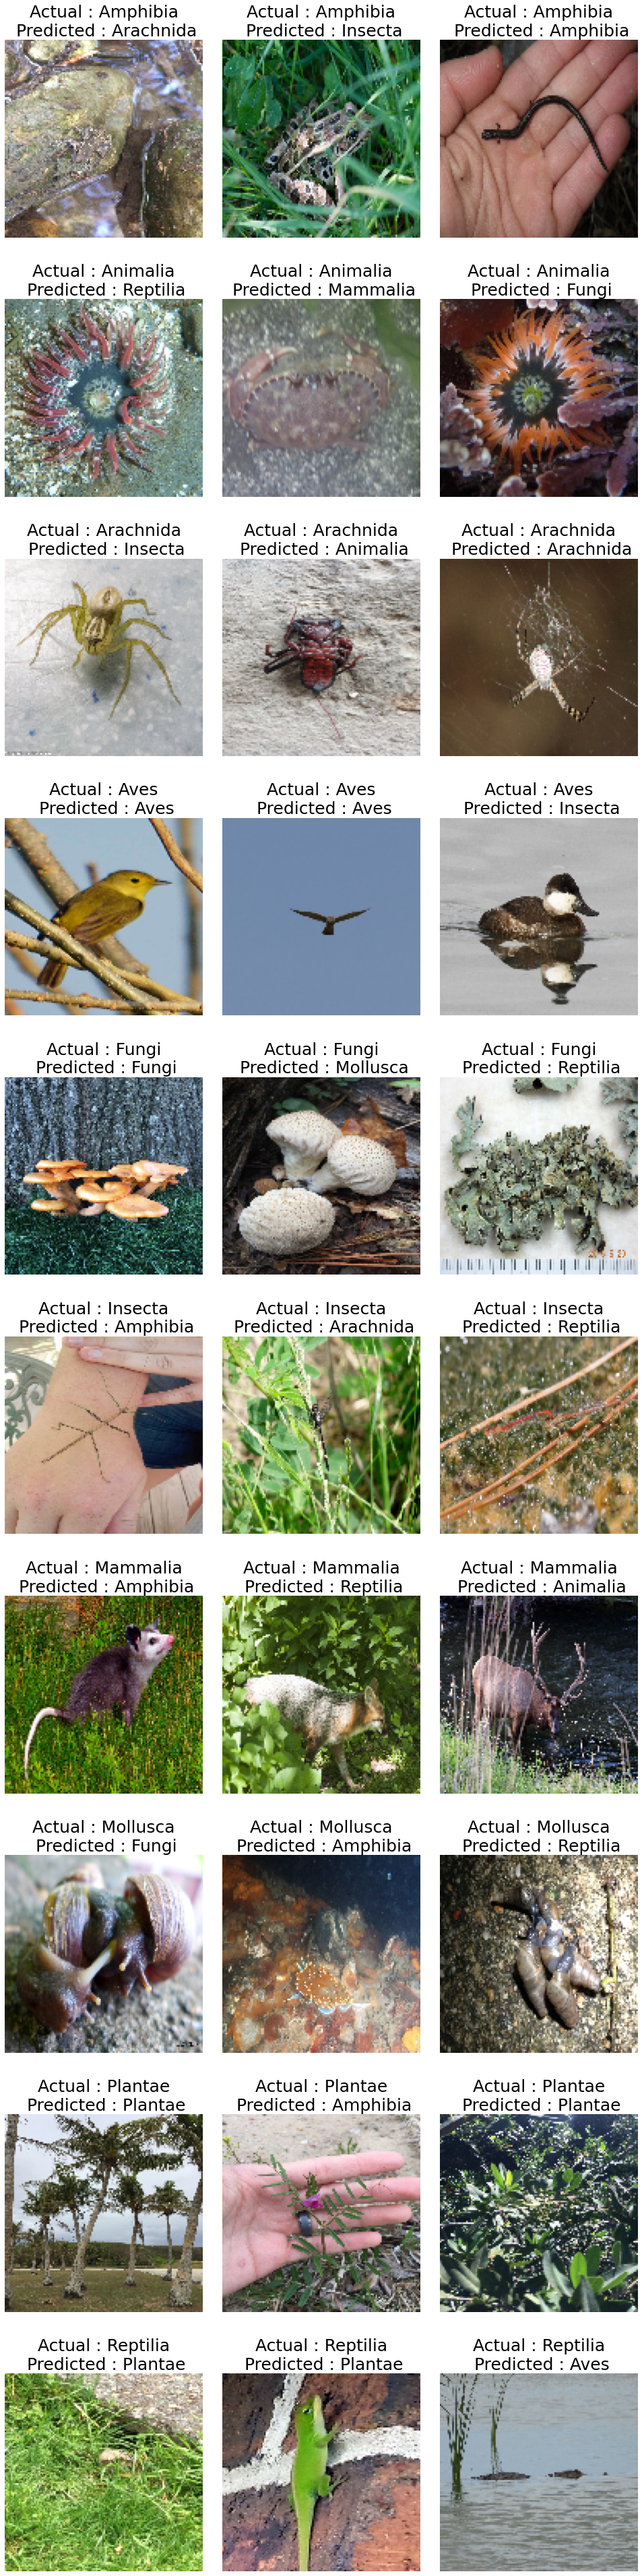

In [ ]:

class_names = ['Amphibia','Animalia','Arachnida','Aves','Fungi','Insecta','Mammalia','Mollusca','Plantae','Reptilia']

fig, axs = plt.subplots(10, 3, figsize=(90, 95))
plt.subplots_adjust(wspace=0.1, hspace=0.3, top=0.60, bottom=0.05, left=0.7, right=0.845)
axs = axs.flatten()


label = 0
row = 0
for ax in axs:
    img = np.where(y_test == label)[0][(row+1)*10]

    ax.set_title("Actual : "+str(class_names[y_test[img]])+"\n Predicted : "+str(class_names[y_pred[img]]),fontdict = {'fontsize':25})
    ax.axis('off')
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.imshow(x_test[img])
    if row == 2:
      row = 0
      label+=1
    else:
      row += 1

plt.savefig("4b.png")

plt.show()

  
    

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_15 (Conv2D)          (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 63, 63, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_16 (Conv2D)          (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 30, 30, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_17 (Conv2D)          (None, 28, 28, 128)       73856     
                                                                 
 max_pooling2d_17 (MaxPoolin  (None, 14, 14, 128)     

<Figure size 3600x3600 with 0 Axes>

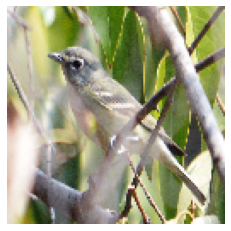

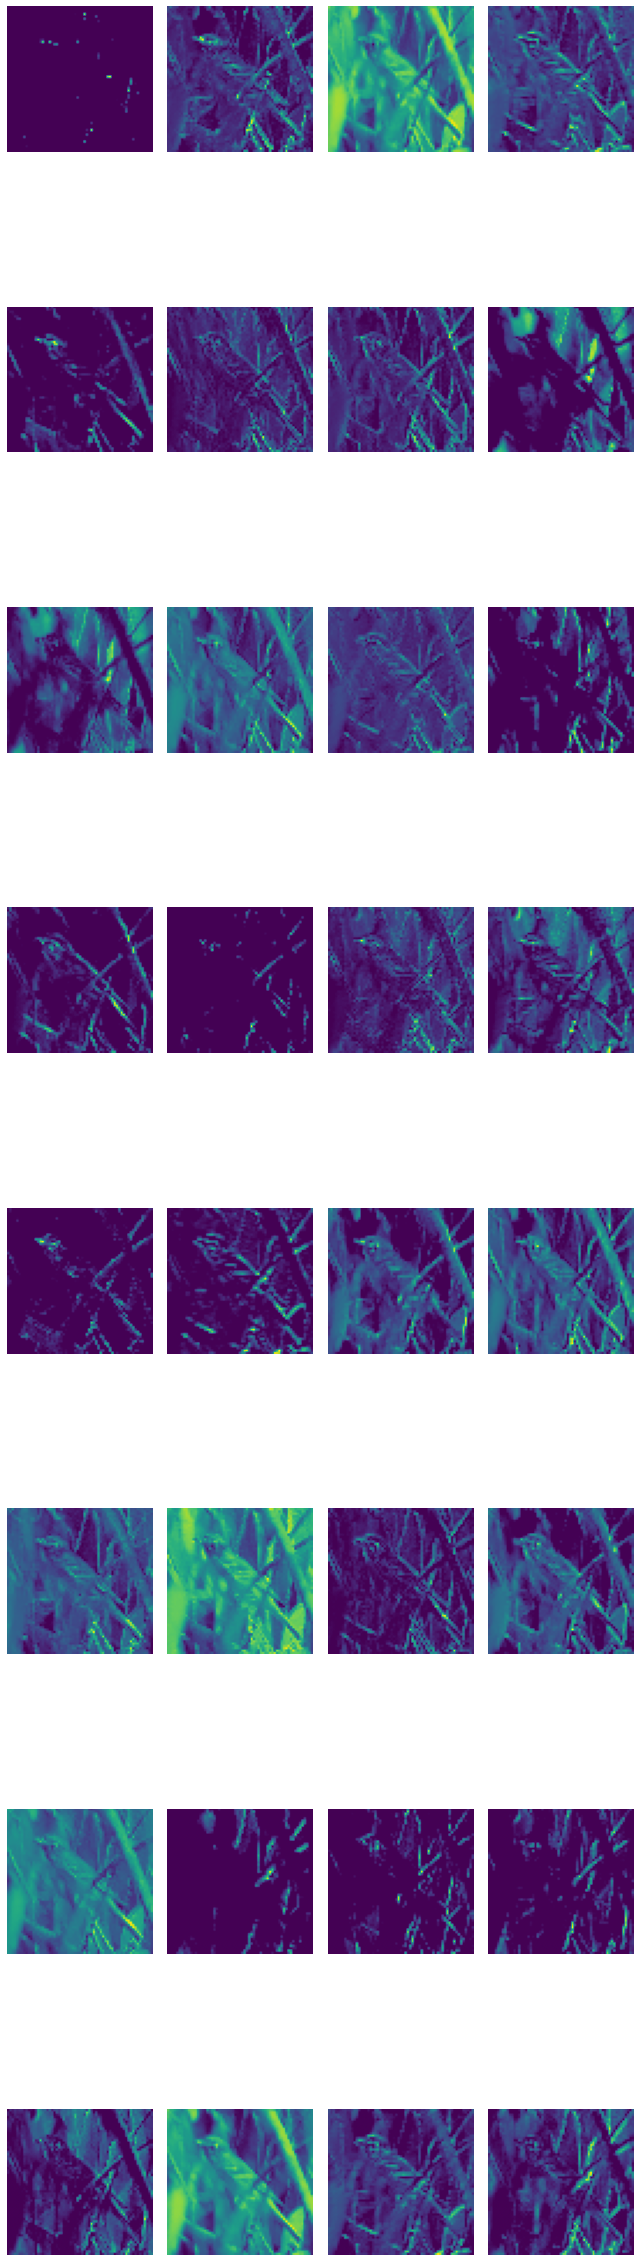

In [ ]:
model = tf.keras.models.load_model('model.h5')
model.summary()

plt.figure(figsize=(50, 50))
# redefine model to output right after the first hidden layer
model = tf.keras.Model(inputs=model.inputs, outputs=model.layers[1].output)
img = np.expand_dims(x_test[153], axis=0)
feature_maps = model.predict(img)

print(feature_maps.shape)


plt.figure(figsize=(4, 4))
plt.imshow(img[0])
plt.axis('off')
plt.show()

fig, axs = plt.subplots(8, 4, figsize=(60, 60))
plt.subplots_adjust(wspace=0.1, hspace=0.1, top=0.60, bottom=0.05, left=0.7, right=0.845)
axs = axs.flatten()


label = -1
for ax in axs:
 label+=1
 ax.axis('off')
 ax.set_xticklabels([])
 ax.set_yticklabels([])
 ax.imshow(feature_maps[0,:,:,label])
 	
	

plt.savefig("4b.png")

plt.show()



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


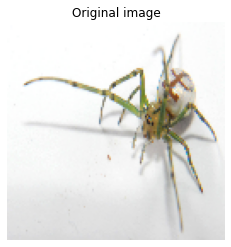

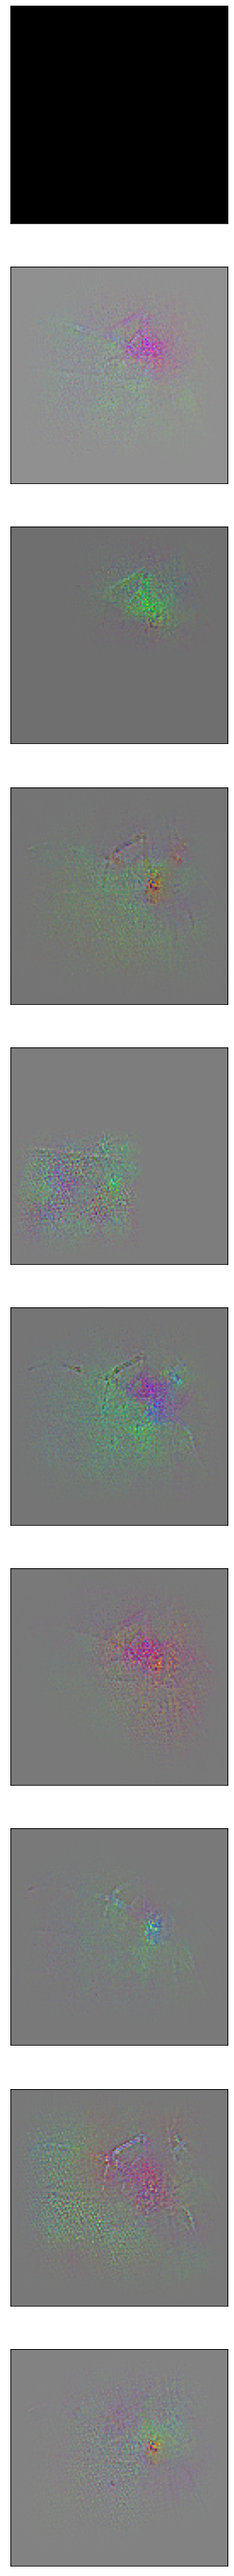

In [ ]:
model = tf.keras.models.load_model('model.h5')
original_img = np.expand_dims(x_test[377], axis=0)

@tf.custom_gradient
def guidedRelU(x):
  def grad(dy):
    return tf.cast(dy>0,"float32") * tf.cast(x>0, "float32") * dy
  return tf.nn.relu(x), grad

for layer in model.layers[1:]:
    if hasattr(layer, 'activation') and layer.activation == tf.keras.activations.selu:
        layer.activation = guidedRelU

grad_image = []

for i in range(0,10):
  activation_model = tf.keras.models.Model(inputs = [model.inputs],outputs = [model.get_layer("conv2d_19").output[:,:,:,i]])

  with tf.GradientTape() as g:
    inputs = tf.cast(original_img, tf.float32)
    g.watch(inputs)
    outputs = activation_model(inputs)[0]

  grad_image.append(g.gradient(outputs,inputs)[0])
                                 

# Guided backprop gradient visualisation

imgs = []

for img in grad_image:
  image = np.dstack((
      img[:,:,0],
      img[:,:,1],
      img[:,:,2]
  ))
  
  
  image = (image - np.min(image))/(np.max(image) - np.min(image))
  imgs.append(image)


plt.title("Original image")
plt.imshow(original_img[0])

plt.axis("off")
plt.savefig('5_original.png')
plt.show()

plt.figure(figsize=(50, 50))


for i in range(10):
		# specify subplot and turn of axis
		ax = plt.subplot(10, 1, i+1)
		ax.set_xticks([])
		ax.set_yticks([])
		
		plt.imshow(imgs[i],cmap = 'gray')
		
# show the figure
plt.savefig('5.png')
plt.show()
